In this blog we will be predicting NBA 2017 winners with Decision Trees in scikit learn.The National Basketball Association (NBA) is the major men's professional basketball league in North America, and is widely considered to be the premier men's professional basketball league in the world. It has 30 teams (29 in the United States and 1 in Canada). The data is available at 
https://www.basketball-reference.com/leagues/NBA_2017_games-october.html. I have assembled the data in a csv file and available in my github folder. This blog is influenced by [this book](https://www.packtpub.com/big-data-and-business-intelligence/learning-data-mining-python).

During the [regular season](https://en.wikipedia.org/wiki/National_Basketball_Association#Regular_season), each team plays 82 games, 41 each home and away. A team faces opponents in its own division four times a year (16 games). Each team plays six of the teams from the other two divisions in its conference four times (24 games), and the remaining four teams three times (12 games). Finally, each team plays all the teams in the other conference twice apiece (30 games). 


In [1]:
#Import the dataset and parse dates
import pandas as pd
df = pd.read_csv("NBA_2017_regularGames.csv",parse_dates=["Date"])

In [2]:
df.head(2)

,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Notes
0,2016-10-25,7:30 pm,New York Knicks,88,Cleveland Cavaliers,117,Box Score,NaN,NaN
1,2016-10-25,10:30 pm,San Antonio Spurs,129,Golden State Warriors,100,Box Score,NaN,NaN


###### The columns names are not clear. Therefore, we will rename the column names.

In [3]:
#Rename the columns
df.columns = ["Date","Time","Visitor Team","Visitor Points","Home Team","Home Points","Score Type","Extra Time","Notes"]

In [4]:
df.head(2)

,Date,Time,Visitor Team,Visitor Points,Home Team,Home Points,Score Type,Extra Time,Notes
0,2016-10-25,7:30 pm,New York Knicks,88,Cleveland Cavaliers,117,Box Score,NaN,NaN
1,2016-10-25,10:30 pm,San Antonio Spurs,129,Golden State Warriors,100,Box Score,NaN,NaN


From the description of how games are played, we can compute a chance rate. In each match, the home team and visitor team has a probability to win half of the time

###### Prediction Class
In the following code we will specify our classification class. This will helps us to see if the prediction from the decision tree classifier is correct or not. We will specify our class as 1 if the home team wins and 0 if the visitor
team wins in another column called "Home Team Win". 

In [5]:
df["Home Team Win"] = df["Visitor Points"] < df["Home Points"]

In [6]:
print("Home Team Win percentage: {0:.1f}%".format(100 * df["Home Team Win"].sum() / df["Home Team Win"].count()))

Home Team Win percentage: 58.4%


###### Separate the classification class

In [7]:
y_true = df["Home Team Win"].values

In [8]:
#The array now holds our class values in a format that scikit-learn can read.
y_true

array([ True, False,  True, ...,  True, False,  True], dtype=bool)

##### Feature Engineering

We will create the following features to help us in predicting NBA 2017 winners.

1. Whether either of the visitor or home team won their last game. 
2. Which team is considered better generally?
3. Which team won their last encounter?



In [9]:
# Let's try see which team is better on the ladder. Using the previous year's ladder
#https://www.basketball-reference.com/leagues/NBA_2016_standings.html
standing = pd.read_csv("ExapandedStanding.csv")

In [30]:
df["Home Last Win"] = False
df["Visitor Last Win"] = False
from collections import defaultdict
won_last = defaultdict(int)
for index, row in df.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["Home Last Win"] = won_last[home_team]
    row["Visitor Last Win"] = won_last[visitor_team]
    df.ix[index] = row
    #We then set our dictionary with the each team's result (from this row) for the next
    #time we see these teams.
    #Set current Win
    won_last[home_team] = row["Home Team Win"]
    won_last[visitor_team] = not row["Home Team Win"]

In [20]:
#Which team won their last encounter

df["Home Win Streak"] = 0
df["Visitor Win Streak"] = 0
win_streak = defaultdict(int)

for index, row in df.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    row["Home Win Streak"] = win_streak[home_team]
    row["Visitor Win Streak"] = win_streak[visitor_team]
    df.ix[index] = row    
    # Set current win
    if row["Home Team Win"]:
        win_streak[home_team] += 1
        win_streak[visitor_team] = 0
    else:
        win_streak[home_team] = 0
        win_streak[visitor_team] += 1

In [25]:
# The standing of the team
df["Home Team Ranks Higher"] = 0
for index , row in df.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    home_rank = standing[standing["Team"] == home_team]["Rk"].values[0]
    visitor_rank = standing[standing["Team"] == visitor_team]["Rk"].values[0]
    row["Home Team Rank Higher"] = int(home_rank > visitor_rank)
    df.ix[index] = row


In [26]:
# Which team won their last encounter team regardless of playing at home
last_match_winner = defaultdict(int)
df["Home Team Won Last"] = 0
for index , row in df.iterrows():
    home_team = row["Home Team"]
    visitor_team = row["Visitor Team"]
    teams = tuple(sorted([home_team, visitor_team]))
    
    row["Home Team Won Last"] = 1 if last_match_winner[teams] == row["Home Team"] else 0
    df.ix[index] = row
    # Who won this one?
    winner = row["Home Team"] if row["Home Team Win"] else row["Visitor Team"]
    last_match_winner[teams] = winner

#### Let us look at the new dataset

In [101]:
df.head(2)

,Date,Time,Visitor Team,Visitor Points,Home Team,Home Points,Score Type,Extra Time,Notes,Home Team Win,Home Win Streak,Visitor Win Streak,Home Team Ranks Higher,Home Team Won Last,Home Last Win,Visitor Last Win
0,2016-10-25,7:30 pm,New York Knicks,88,Cleveland Cavaliers,117,Box Score,NaN,NaN,True,0,0,0,0,False,False
1,2016-10-25,10:30 pm,San Antonio Spurs,129,Golden State Warriors,100,Box Score,NaN,NaN,False,0,0,0,0,False,False


The scikit-learn package implements the CART (Classification and Regression
Trees) algorithm as its default [decision tree class](http://scikit-learn.org/stable/modules/tree.html)

The decision tree implementation provides a method to stop the
building of a tree to prevent overfitting using the following options:

    • min_samples_split: can create arbitrary small leaves in order to create a new node in the decision tree


    • min_samples_leaf: guarantees a minimum number of samples in a leaf resultingfrom a node
    
It is recommended to use min_samples_split or min_samples_leaf to control the number of samples at a leaf node. A very small number will usually mean the tree will overfit, whereas a large number will prevent the tree from learning the data. 

Another parameter for decision tress is the criterion for creating a decision.
Gini impurity and Information gain are two popular ones:

    • Gini impurity: measures how often a decision node would incorrectly predict a sample's class

    •`Information gain: indicate how much extra information is gained by the decision node


#### Feature Selection

We extract the features from the dataset to use with our scikit-learn's DecisionTreeClassifier by specifying the columns we
wish to use and using the values parameter of a view of the data frame. We use the cross_val_score function to test the result. 

In [102]:
X_features_only = df[['Home Win Streak', 'Visitor Win Streak', 'Home Team Ranks Higher',
       'Home Team Won Last', 'Home Last Win', 'Visitor Last Win']].values

In [103]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=14)
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf, X_features_only, y_true, scoring='accuracy')
print(scores)
print("Using just the last result from the home and visitor teams")
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

[ 0.55961071  0.54878049  0.57212714]
Using just the last result from the home and visitor teams
Accuracy: 56.0%


The accuracy drops to 56% by just selecting the features we made. Is it possible to increase the accuracy by adding more features.

In [46]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
encoding = LabelEncoder()
#We will fit this transformer to the home teams so that it learns an integer
#representation for each team
encoding.fit(df["Home Team"].values)

home_teams = encoding.transform(df["Home Team"].values)
visitor_teams = encoding.transform(df["Visitor Team"].values)
X_teams = np.vstack([home_teams, visitor_teams]).T

#we use the OneHotEncoder transformer to encode 

onehot = OneHotEncoder()
#We fit and transform 
X_teams = onehot.fit_transform(X_teams).todense()



In [93]:
X_all = np.hstack([X_features_only, X_teams])

#we run the decision tree on the new dataset
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, X_all, y_true, scoring='accuracy')
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

Accuracy: 56.6%


In [87]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import sklearn.metrics

In [88]:
X_small = df[['Home Team Ranks Higher', 'Home Win Streak']]
pred_train, pred_test, tar_train, tar_test  =   train_test_split(X_small, y_true, test_size=.4)


In [89]:
#Build model on training data
classifier=DecisionTreeClassifier()
classifier=classifier.fit(pred_train,tar_train)

predictions=classifier.predict(pred_test)

sklearn.metrics.confusion_matrix(tar_test,predictions)

array([[  1, 195],
       [  1, 295]])

Confusion Matrix shows the correct and incorrect classifications of our decision tree. The diagonal, 1,295 represent the number of true negative for home team, and the number of true positives, respectively. The 1, on the bottom left, represents the number of false negatives. And the 195 on the top right, the number of false positives. We can also look at the accuracy score which is approximately 0.602, which suggests that the decision tree model has classified 60.2% of the sample correctly as either home team winning or not.

In [94]:
sklearn.metrics.accuracy_score(tar_test, predictions)
print("Accuracy: {0:.1f}%".format(sklearn.metrics.accuracy_score(tar_test, predictions) * 100))

Accuracy: 60.2%


##### We have an accuracy of 60.2% by selecting only these two features.

In [96]:
#Displaying the decision tree
from sklearn import tree
#from StringIO import StringIO
from io import StringIO
#from StringIO import StringIO 
from IPython.display import Image
out = StringIO()
tree.export_graphviz(classifier, out_file=out)



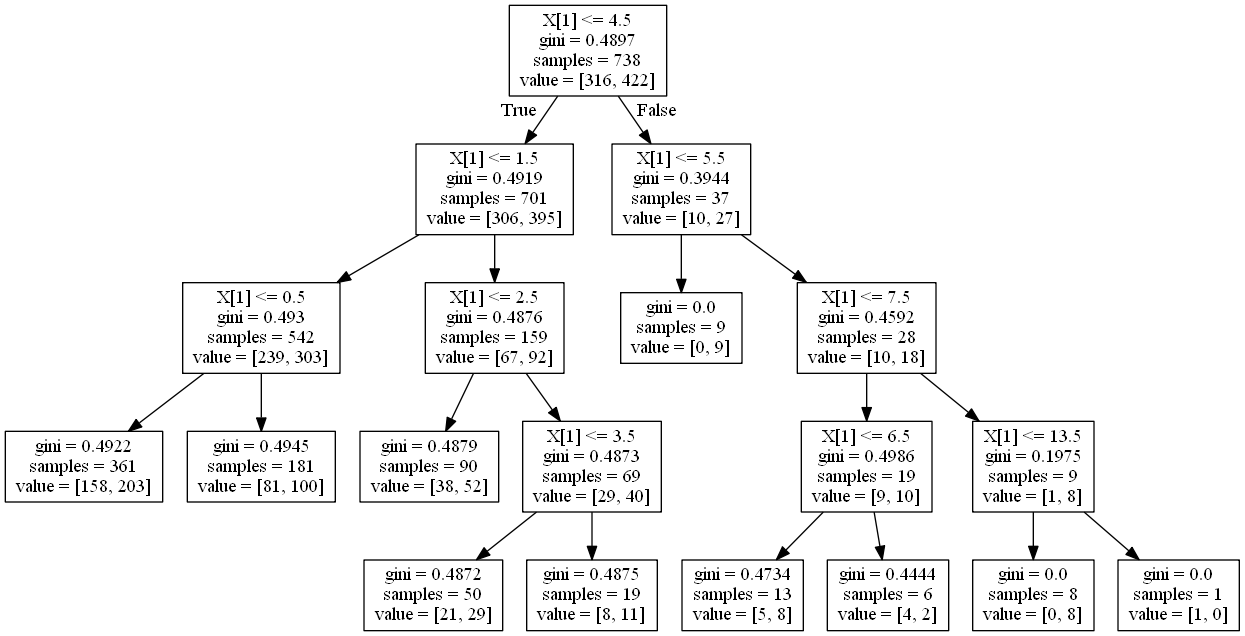

In [97]:
import pydotplus
graph=pydotplus.graph_from_dot_data(out.getvalue())
Image(graph.create_png())


For exploratory purposes it can be helpful to test smaller number of variables in order to first get the feel for the decision tree output.
The resulting tree starts with the split on X, our first explanatory variable, Home Team Ranks Higher. If the value for Home Team Ranks Higher is less than 4.5, that is home team loose since our binary variable has values of false equal loss and true equal win. 

By default, SKLearn uses the genie index as the splitting criteria for splitting internal nodes into additional internal or terminal ones. Sometimes called parent and child nodes, as this tree is grown. The goal of the partitioning that occurs when a decision tree is grown is to recursively subdivide in such a way that the values of the target variable for the observations in the terminal or leaf nodes are as similar as possible.

###### Based on the grow criteria that is selected, the growth process continues, often until it over fits the data. And is likely to perform poorly by not adequately generalizing to new data.

Notably, while decision trees such as this one are easy to interpret, it's also important to recognize that small changes in the data or decisions that we make about the modeling approach lead to very different splits.

### Random forests

Random forests averages randomly built decision trees, resulting in an algorithm that
reduces the variance of the result. These use subsets of the features which should be able to learn more
effectively with more features than normal decision trees. 

Random forests share many of the same
parameters with Decision Trees such as the criterion (Gini Impurity or Entropy/Information Gain),
max_features, and min_samples_split.

Also, there are some new parameters that are used in the ensemble process:
    
    • n_estimators: dictates how many decision trees should be built. A higher value will take longer to run, but will (probably) result in a higher accuracy.
    • oob_score: If true, the method is tested using samples that aren't in the random subsamples chosen for training the decision trees.
    • n_jobs: specifies the number of cores to use when training the decision trees in parallel.

In [98]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(random_state=14)
scores = cross_val_score(clf, X_all, y_true, scoring='accuracy')
print("Using full team labels is ranked higher")
print("Accuracy: {0:.1f}%".format(np.mean(scores) * 100))

Using full team labels is ranked higher
Accuracy: 57.2%


##### This results in an immediate benefit of 57.2 percent by using Random Forest Classifier




In [99]:
from sklearn.model_selection import GridSearchCV

parameter_space = {
"max_features": [2, 10, 'auto'],
"n_estimators": [100,],
"criterion": ["gini", "entropy"],
"min_samples_leaf": [2, 4, 6],
}
clf = RandomForestClassifier(random_state=14)
grid = GridSearchCV(clf, parameter_space)
grid.fit(X_all, y_true)
print("Accuracy: {0:.1f}%".format(grid.best_score_ * 100))

Accuracy: 61.5%


###### This has a much better accuracy of 61.5 percent!
If we wanted to see the parameters used, we can print out the best model that was
found in the grid search.

In [100]:
print(grid.best_estimator_)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=None, max_features=2, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=14,
            verbose=0, warm_start=False)
